<a href="https://colab.research.google.com/github/Nisha40108/ADVANCED-MACHINE-LEARNING-64061-/blob/main/Assignment_4_Text%26Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 4 - Text and Sequence Data using IMDB dataset**

# **Name: Nisha Chaurasia**

# **Date: 11-26-2023**

In [150]:
!pip install tensorflow==2.12

**Loading the important libraries**

In [151]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True

**Importing TensorFlow and Keras:**

In [152]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from google.colab import files
import re, os

#### Considering the IMDB example from Chapter 6. Re-running the example and modifying the  by **implementing a cutoff for reviews after 150 words, Validation Sample - 10000, Consider only the top 10,000 words**

### **Model 1: Basic model just using embadded layer with  Training Sample - 100**

In [154]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)


# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=100, test_size=10000, random_state=42, stratify=labels)
# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [156]:
train_texts.shape

(100, 150)

In [157]:
val_texts.shape

(10000, 150)

In [158]:
test_texts.shape

(5000, 150)

**Model Building**

In [159]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_8 (Flatten)         (None, 1200)              0         
                                                                 
 dense_19 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


**Model Execution**

In [162]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model1.h5",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_1 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 2s 316ms/step - loss: 0.6959 - accuracy: 0.4400 - val_loss: 0.6932 - val_accuracy: 0.4978
Epoch 2/30
4/4 [==============================] - 1s 275ms/step - loss: 0.6728 - accuracy: 0.8200 - val_loss: 0.6931 - val_accuracy: 0.5039
Epoch 3/30
4/4 [==============================] - 1s 274ms/step - loss: 0.6574 - accuracy: 0.9400 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 4/30
4/4 [==============================] - 1s 302ms/step - loss: 0.6436 - accuracy: 0.9900 - val_loss: 0.6930 - val_accuracy: 0.5072
Epoch 5/30
4/4 [==============================] - 1s 282ms/step - loss: 0.6302 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5078
Epoch 6/30
4/4 [==============================] - 1s 310ms/step - loss: 0.6165 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5105
Epoch 7/30
4/4 [==============================] - 1s 299ms/step - loss: 0.6027 - accuracy: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5080
Epoch 8/30
4/4 [====

**Ploating the Accuracy and loss for training and validation**

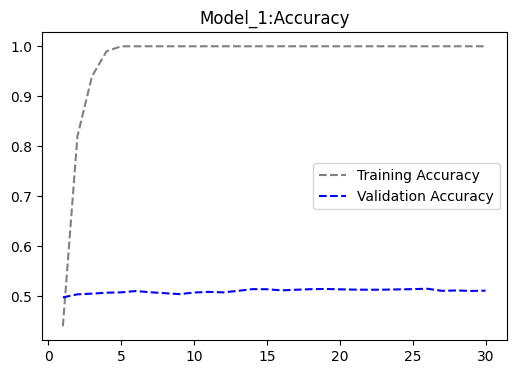

<Figure size 640x480 with 0 Axes>

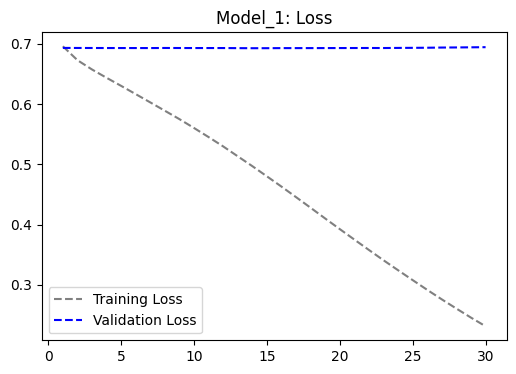

In [163]:
accuracy = Model_1.history['accuracy']
val_accuracy = Model_1.history['val_accuracy']

loss = Model_1.history["loss"]
val_loss = Model_1.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_1:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_1: Loss")
plt.legend()
plt.show()

In [164]:
test_model = load_model('model1.h5')
Model1_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

157/157 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.5064
Loss: 0.694
Accuracy: 0.506


The model with 100 training samples which was built with just an embedding layer resulted in 51.7% Accuracy, which is not that bad because the model was just trained with 100 Samples.

### **Model 2: Increasing the training sample to 5000 and with just Embedding Layer**

In [167]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=5000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [168]:
train_texts.shape

(5000, 150)

In [169]:
val_texts.shape

(10000, 150)

In [170]:
test_texts.shape

(5000, 150)

In [171]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_9 (Flatten)         (None, 1200)              0         
                                                                 
 dense_20 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


In [172]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model2.h5",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_2 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
157/157 [==============================] - 12s 74ms/step - loss: 0.6917 - accuracy: 0.5202 - val_loss: 0.6871 - val_accuracy: 0.5773
Epoch 2/30
157/157 [==============================] - 6s 37ms/step - loss: 0.6553 - accuracy: 0.7412 - val_loss: 0.6438 - val_accuracy: 0.6924
Epoch 3/30
157/157 [==============================] - 4s 27ms/step - loss: 0.5583 - accuracy: 0.8118 - val_loss: 0.5475 - val_accuracy: 0.7805
Epoch 4/30
157/157 [==============================] - 3s 17ms/step - loss: 0.4307 - accuracy: 0.8734 - val_loss: 0.4601 - val_accuracy: 0.8134
Epoch 5/30
157/157 [==============================] - 2s 16ms/step - loss: 0.3278 - accuracy: 0.9106 - val_loss: 0.4057 - val_accuracy: 0.8303
Epoch 6/30
157/157 [==============================] - 2s 15ms/step - loss: 0.2553 - accuracy: 0.9282 - val_loss: 0.3778 - val_accuracy: 0.8405
Epoch 7/30
157/157 [==============================] - 2s 13ms/step - loss: 0.2034 - accuracy: 0.9468 - val_loss: 0.3658 - val_accuracy: 0.839

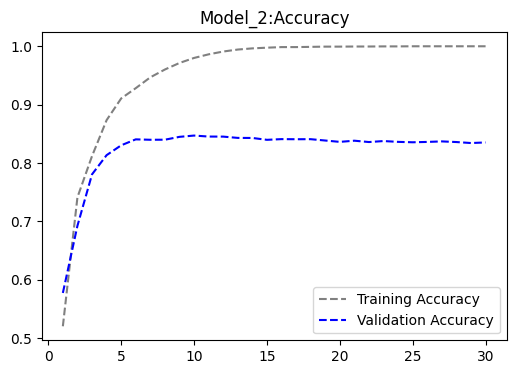

<Figure size 640x480 with 0 Axes>

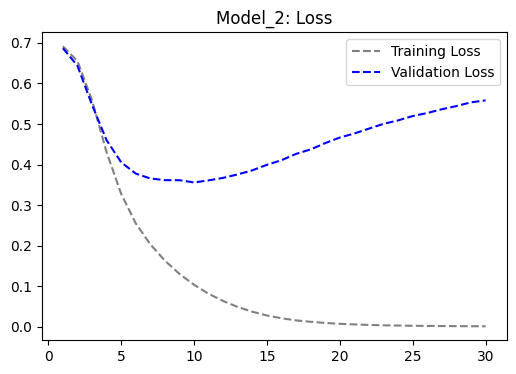

In [173]:
accuracy = Model_2.history['accuracy']
val_accuracy = Model_2.history['val_accuracy']

loss = Model_2.history["loss"]
val_loss = Model_2.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_2:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_2: Loss")
plt.legend()
plt.show()

In [174]:
test_model = load_model('model2.h5')
Model2_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model2_Results[0]:.3f}')
print(f'Accuracy: {Model2_Results[1]:.3f}')

157/157 [==============================] - 0s 2ms/step - loss: 0.3191 - accuracy: 0.8670
Loss: 0.319
Accuracy: 0.867


Model 3: Increase training size to 10000, everything else same

In [175]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=10000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [176]:
train_texts.shape

(10000, 150)

In [177]:
val_texts.shape

(10000, 150)

In [178]:
test_texts.shape

(5000, 150)

In [179]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 150, 8)            80000     
                                                                 
 flatten_10 (Flatten)        (None, 1200)              0         
                                                                 
 dense_21 (Dense)            (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


In [180]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model3.h5",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
Model_3 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 19s 58ms/step - loss: 0.6827 - accuracy: 0.5758 - val_loss: 0.6466 - val_accuracy: 0.7142
Epoch 2/30
313/313 [==============================] - 5s 17ms/step - loss: 0.5261 - accuracy: 0.8046 - val_loss: 0.4480 - val_accuracy: 0.8245
Epoch 3/30
313/313 [==============================] - 4s 12ms/step - loss: 0.3540 - accuracy: 0.8699 - val_loss: 0.3615 - val_accuracy: 0.8469
Epoch 4/30
313/313 [==============================] - 3s 9ms/step - loss: 0.2752 - accuracy: 0.8950 - val_loss: 0.3299 - val_accuracy: 0.8600
Epoch 5/30
313/313 [==============================] - 3s 9ms/step - loss: 0.2281 - accuracy: 0.9155 - val_loss: 0.3207 - val_accuracy: 0.8628
Epoch 6/30
313/313 [==============================] - 3s 8ms/step - loss: 0.1936 - accuracy: 0.9307 - val_loss: 0.3198 - val_accuracy: 0.8642
Epoch 7/30
313/313 [==============================] - 2s 7ms/step - loss: 0.1653 - accuracy: 0.9442 - val_loss: 0.3163 - val_accuracy: 0.8665
Ep

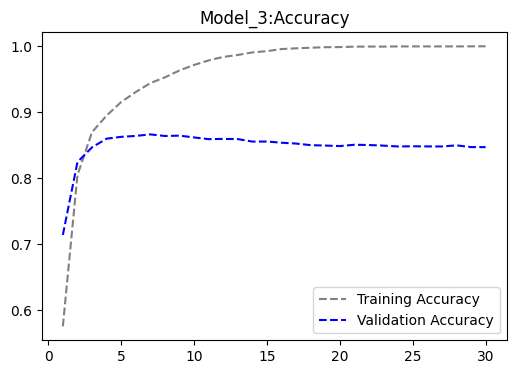

<Figure size 640x480 with 0 Axes>

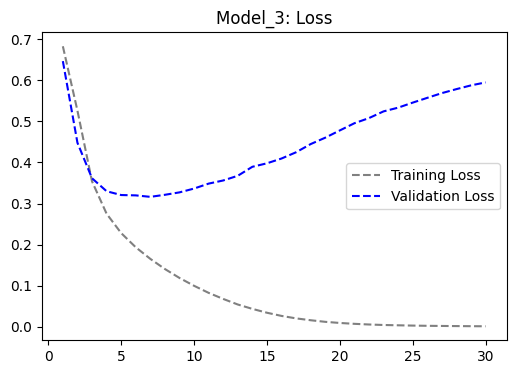

In [181]:
accuracy = Model_3.history['accuracy']
val_accuracy = Model_3.history['val_accuracy']

loss = Model_3.history["loss"]
val_loss = Model_3.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_3:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_3: Loss")
plt.legend()
plt.show()

In [182]:
test_model = load_model('model3.h5')
Model3_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model3_Results[0]:.3f}')
print(f'Accuracy: {Model3_Results[1]:.3f}')

157/157 [==============================] - 0s 2ms/step - loss: 0.2794 - accuracy: 0.8780
Loss: 0.279
Accuracy: 0.878


Model 4: Use same training size but use convolution 1D and Embadding layer together

In [183]:
model = Sequential()

maxlen = 150
model.add(Embedding(10000, 8, input_length=maxlen))

model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(256, 3, activation='relu'))
model.add(Dropout(0.8))
model.add(MaxPooling1D(3))

model.add(GlobalMaxPooling1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compiling the Model
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 150, 8)            80000     
                                                                 
 conv1d_9 (Conv1D)           (None, 148, 512)          12800     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 49, 512)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 47, 256)           393472    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 15, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          (None, 13, 256)         

In [184]:
callbacks = ModelCheckpoint(
            filepath= "model4.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_4 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 28s 84ms/step - loss: 0.6930 - accuracy: 0.5057 - val_loss: 0.6927 - val_accuracy: 0.5277
Epoch 2/30
313/313 [==============================] - 9s 28ms/step - loss: 0.6371 - accuracy: 0.6201 - val_loss: 0.6167 - val_accuracy: 0.7291
Epoch 3/30
313/313 [==============================] - 5s 17ms/step - loss: 0.4349 - accuracy: 0.7997 - val_loss: 0.5500 - val_accuracy: 0.7858
Epoch 4/30
313/313 [==============================] - 4s 13ms/step - loss: 0.3387 - accuracy: 0.8528 - val_loss: 0.5145 - val_accuracy: 0.8108
Epoch 5/30
313/313 [==============================] - 4s 14ms/step - loss: 0.2803 - accuracy: 0.8852 - val_loss: 0.4822 - val_accuracy: 0.8138
Epoch 6/30
313/313 [==============================] - 4s 12ms/step - loss: 0.2354 - accuracy: 0.9049 - val_loss: 0.4730 - val_accuracy: 0.8072
Epoch 7/30
313/313 [==============================] - 4s 12ms/step - loss: 0.1843 - accuracy: 0.9318 - val_loss: 0.4496 - val_accuracy: 0.812

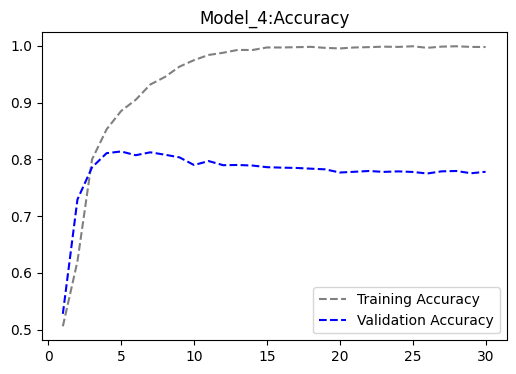

<Figure size 640x480 with 0 Axes>

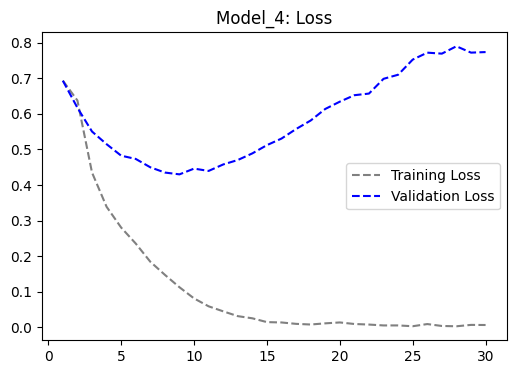

In [185]:
accuracy = Model_4.history['accuracy']
val_accuracy = Model_4.history['val_accuracy']

loss = Model_4.history["loss"]
val_loss = Model_4.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_4:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_4: Loss")
plt.legend()
plt.show()

In [186]:
test_model = load_model('model4.h5')
Model4_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model4_Results[0]:.3f}')
print(f'Accuracy: {Model4_Results[1]:.3f}')

157/157 [==============================] - 1s 4ms/step - loss: 0.3904 - accuracy: 0.8444
Loss: 0.390
Accuracy: 0.844


Model:5 A sequence model built on one-hot encoded vector sequences

In [187]:
import tensorflow as tf
max_length = 150
max_tokens = 10000
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot_1 (TFOpLambda)   (None, None, 10000)       0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               2568448   
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,568,513
Trainable params: 2,568,513
Non-trainable params: 0
_________________________________________________

In [188]:
callbacks = ModelCheckpoint(
            filepath= "model5.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_5 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 21s 55ms/step - loss: 0.5929 - accuracy: 0.6762 - val_loss: 0.4433 - val_accuracy: 0.8083
Epoch 2/30
313/313 [==============================] - 17s 54ms/step - loss: 0.3908 - accuracy: 0.8492 - val_loss: 0.3669 - val_accuracy: 0.8393
Epoch 3/30
313/313 [==============================] - 17s 54ms/step - loss: 0.3065 - accuracy: 0.8840 - val_loss: 0.3381 - val_accuracy: 0.8545
Epoch 4/30
313/313 [==============================] - 17s 55ms/step - loss: 0.2584 - accuracy: 0.9026 - val_loss: 0.3274 - val_accuracy: 0.8619
Epoch 5/30
313/313 [==============================] - 17s 55ms/step - loss: 0.2173 - accuracy: 0.9247 - val_loss: 0.3716 - val_accuracy: 0.8423
Epoch 6/30
313/313 [==============================] - 17s 56ms/step - loss: 0.1870 - accuracy: 0.9350 - val_loss: 0.3228 - val_accuracy: 0.8656
Epoch 7/30
313/313 [==============================] - 17s 55ms/step - loss: 0.1528 - accuracy: 0.9514 - val_loss: 0.4606 - val_accuracy:

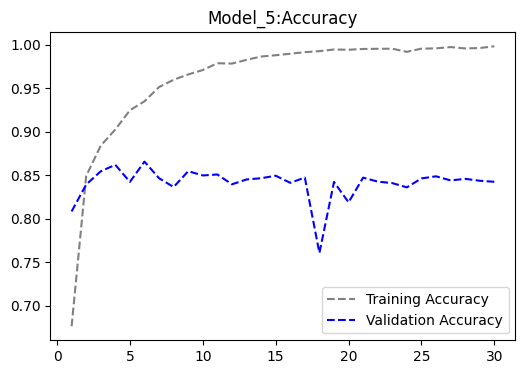

<Figure size 640x480 with 0 Axes>

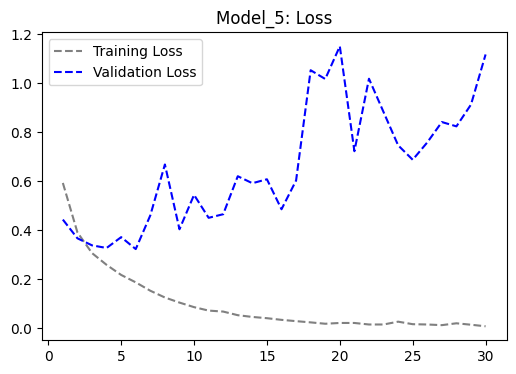

In [190]:
accuracy = Model_5.history['accuracy']
val_accuracy = Model_5.history['val_accuracy']

loss = Model_5.history["loss"]
val_loss = Model_5.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_5:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_5: Loss")
plt.legend()
plt.show()

In [191]:
test_model = load_model('model5.h5')
Model5_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model5_Results[0]:.3f}')
print(f'Accuracy: {Model5_Results[1]:.3f}')

157/157 [==============================] - 4s 19ms/step - loss: 0.2818 - accuracy: 0.8864
Loss: 0.282
Accuracy: 0.886


Model 6: LSTM

In [192]:
max_length = 150
max_tokens = 10000
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_19 (Embedding)    (None, None, 256)         2560000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [193]:
callbacks = ModelCheckpoint(
            filepath= "model6.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_6 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 33s 48ms/step - loss: 0.4638 - accuracy: 0.7796 - val_loss: 0.3592 - val_accuracy: 0.8429
Epoch 2/30
625/625 [==============================] - 11s 18ms/step - loss: 0.3018 - accuracy: 0.8807 - val_loss: 0.2967 - val_accuracy: 0.8748
Epoch 3/30
625/625 [==============================] - 10s 17ms/step - loss: 0.2495 - accuracy: 0.9043 - val_loss: 0.2969 - val_accuracy: 0.8766
Epoch 4/30
625/625 [==============================] - 10s 17ms/step - loss: 0.2173 - accuracy: 0.9197 - val_loss: 0.3013 - val_accuracy: 0.8741
Epoch 5/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1841 - accuracy: 0.9329 - val_loss: 0.3306 - val_accuracy: 0.8737
Epoch 6/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1568 - accuracy: 0.9438 - val_loss: 0.4055 - val_accuracy: 0.8742
Epoch 7/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1321 - accuracy: 0.9546 - val_loss: 0.4520 - val_accuracy: 0.

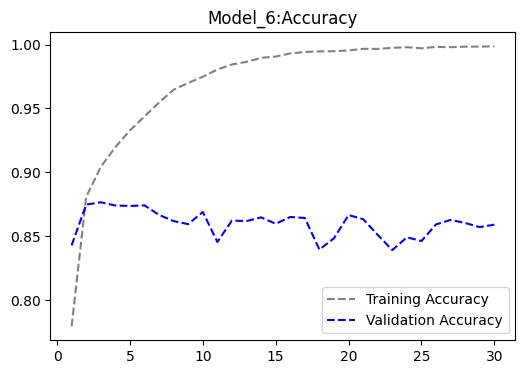

<Figure size 640x480 with 0 Axes>

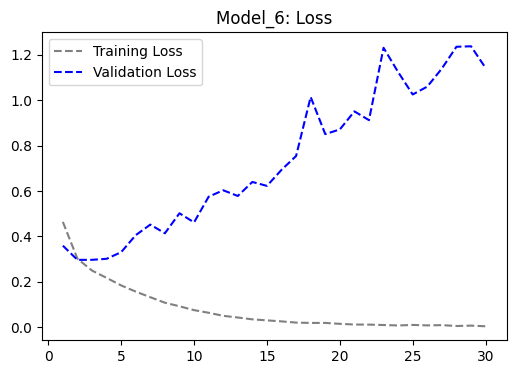

In [194]:
accuracy = Model_6.history['accuracy']
val_accuracy = Model_6.history['val_accuracy']

loss = Model_6.history["loss"]
val_loss = Model_6.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_6:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_6: Loss")
plt.legend()
plt.show()

In [195]:
test_model = load_model('model6.h5')
Model6_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model6_Results[0]:.3f}')
print(f'Accuracy: {Model6_Results[1]:.3f}')

157/157 [==============================] - 2s 6ms/step - loss: 0.2629 - accuracy: 0.8934
Loss: 0.263
Accuracy: 0.893


Model 6.1 LSTM with higher training sample 20000

In [196]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)

# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=20000, test_size=10000, random_state=42, stratify=labels)

# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)

In [197]:
train_texts.shape

(20000, 150)

In [198]:
val_texts.shape

(10000, 150)

In [199]:
max_length = 150
max_tokens = 10000
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_20 (Embedding)    (None, None, 256)         2560000   
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [202]:
callbacks = ModelCheckpoint(
            filepath= "model61.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_61 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 23s 37ms/step - loss: 0.4367 - accuracy: 0.8060 - val_loss: 0.3394 - val_accuracy: 0.8462
Epoch 2/30
625/625 [==============================] - 12s 19ms/step - loss: 0.2979 - accuracy: 0.8791 - val_loss: 0.3103 - val_accuracy: 0.8709
Epoch 3/30
625/625 [==============================] - 10s 17ms/step - loss: 0.2498 - accuracy: 0.9022 - val_loss: 0.3040 - val_accuracy: 0.8754
Epoch 4/30
625/625 [==============================] - 9s 15ms/step - loss: 0.2123 - accuracy: 0.9203 - val_loss: 0.3732 - val_accuracy: 0.8489
Epoch 5/30
625/625 [==============================] - 9s 15ms/step - loss: 0.1887 - accuracy: 0.9318 - val_loss: 0.3171 - val_accuracy: 0.8722
Epoch 6/30
625/625 [==============================] - 10s 16ms/step - loss: 0.1592 - accuracy: 0.9431 - val_loss: 0.3424 - val_accuracy: 0.8700
Epoch 7/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1325 - accuracy: 0.9534 - val_loss: 0.3423 - val_accuracy: 0.

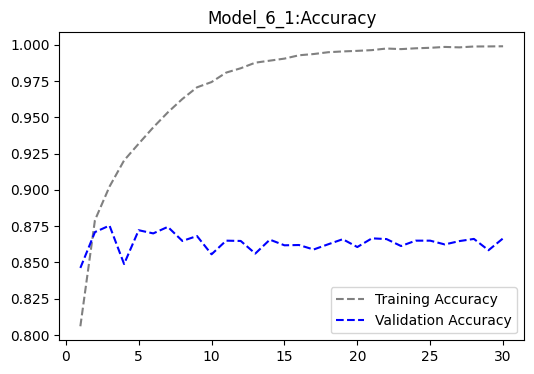

<Figure size 640x480 with 0 Axes>

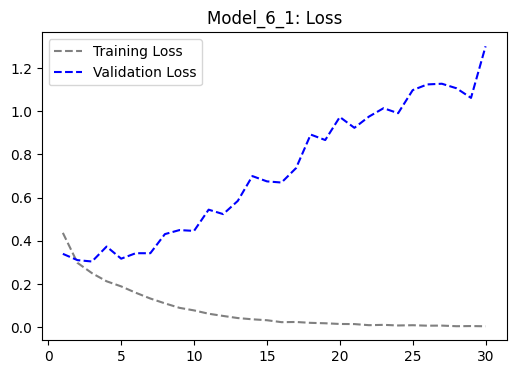

In [205]:
accuracy = Model_61.history['accuracy']
val_accuracy = Model_61.history['val_accuracy']

loss = Model_61.history["loss"]
val_loss = Model_61.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_6_1:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_6_1: Loss")
plt.legend()
plt.show()

In [206]:
test_model = load_model('model61.h5')
Model6_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model6_Results[0]:.3f}')
print(f'Accuracy: {Model6_Results[1]:.3f}')

157/157 [==============================] - 2s 6ms/step - loss: 0.2541 - accuracy: 0.8998
Loss: 0.254
Accuracy: 0.900


Model7 : Masking enable

In [207]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_21 (Embedding)    (None, None, 256)         2560000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [209]:
callbacks = ModelCheckpoint(
            filepath= "model7.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_7 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 178s 279ms/step - loss: 0.4426 - accuracy: 0.7870 - val_loss: 0.3349 - val_accuracy: 0.8504
Epoch 2/30
625/625 [==============================] - 156s 249ms/step - loss: 0.2891 - accuracy: 0.8827 - val_loss: 0.3036 - val_accuracy: 0.8689
Epoch 3/30
625/625 [==============================] - 154s 246ms/step - loss: 0.2342 - accuracy: 0.9087 - val_loss: 0.3040 - val_accuracy: 0.8741
Epoch 4/30
625/625 [==============================] - 152s 243ms/step - loss: 0.1922 - accuracy: 0.9279 - val_loss: 0.3212 - val_accuracy: 0.8744
Epoch 5/30
625/625 [==============================] - 151s 242ms/step - loss: 0.1591 - accuracy: 0.9435 - val_loss: 0.3363 - val_accuracy: 0.8701
Epoch 6/30
625/625 [==============================] - 151s 241ms/step - loss: 0.1235 - accuracy: 0.9574 - val_loss: 0.3452 - val_accuracy: 0.8666
Epoch 7/30
625/625 [==============================] - 151s 242ms/step - loss: 0.0996 - accuracy: 0.9660 - val_loss: 0.4211 -

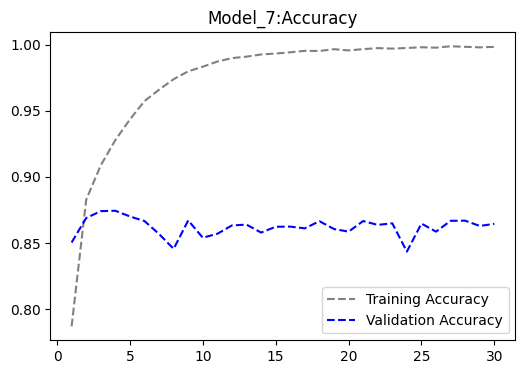

<Figure size 640x480 with 0 Axes>

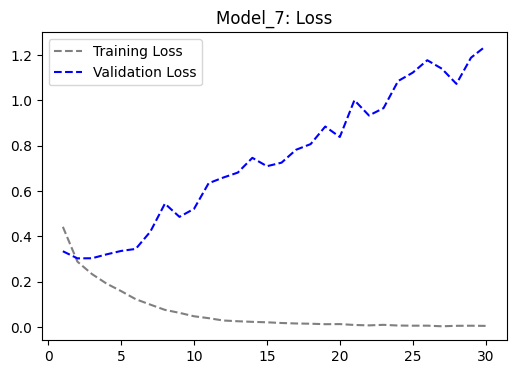

In [210]:
accuracy = Model_7.history['accuracy']
val_accuracy = Model_7.history['val_accuracy']

loss = Model_7.history["loss"]
val_loss = Model_7.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_7:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_7: Loss")
plt.legend()
plt.show()

In [211]:
test_model = load_model('model7.h5')
Model7_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model7_Results[0]:.3f}')
print(f'Accuracy: {Model7_Results[1]:.3f}')

157/157 [==============================] - 11s 55ms/step - loss: 0.2676 - accuracy: 0.8878
Loss: 0.268
Accuracy: 0.888


Model 8: TRansformers

In [213]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [214]:
vocab_size = 10000
embed_dim = 150
num_heads = 2
dense_dim = 32
maxlen = 150

inputs = keras.Input(shape=(maxlen,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150)]             0         
                                                                 
 embedding_23 (Embedding)    (None, 150, 150)          1500000   
                                                                 
 transformer_encoder (Transf  (None, 150, 150)         191432    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d_4 (Glo  (None, 150)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_13 (Dropout)        (None, 150)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 151 

In [215]:
callbacks = ModelCheckpoint(
            filepath= "model8.h5",
            save_best_only= True,
            monitor= "val_loss"
            )

Model_8 = model.fit(train_texts, train_labels,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 35s 52ms/step - loss: 0.4837 - accuracy: 0.7745 - val_loss: 0.3313 - val_accuracy: 0.8539
Epoch 2/30
625/625 [==============================] - 11s 18ms/step - loss: 0.3138 - accuracy: 0.8662 - val_loss: 0.3135 - val_accuracy: 0.8626
Epoch 3/30
625/625 [==============================] - 8s 13ms/step - loss: 0.2623 - accuracy: 0.8942 - val_loss: 0.2979 - val_accuracy: 0.8741
Epoch 4/30
625/625 [==============================] - 7s 12ms/step - loss: 0.2293 - accuracy: 0.9097 - val_loss: 0.3132 - val_accuracy: 0.8679
Epoch 5/30
625/625 [==============================] - 7s 11ms/step - loss: 0.2024 - accuracy: 0.9204 - val_loss: 0.3346 - val_accuracy: 0.8689
Epoch 6/30
625/625 [==============================] - 7s 12ms/step - loss: 0.1851 - accuracy: 0.9298 - val_loss: 0.3078 - val_accuracy: 0.8719
Epoch 7/30
625/625 [==============================] - 6s 10ms/step - loss: 0.1683 - accuracy: 0.9363 - val_loss: 0.3322 - val_accuracy: 0.87

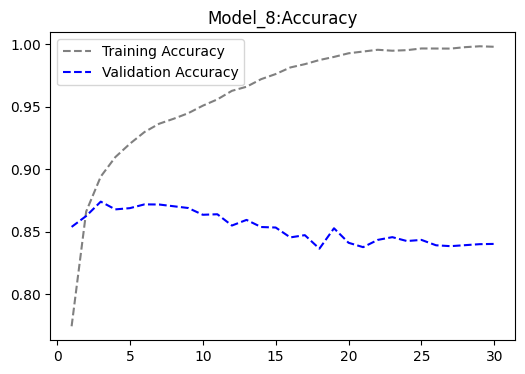

<Figure size 640x480 with 0 Axes>

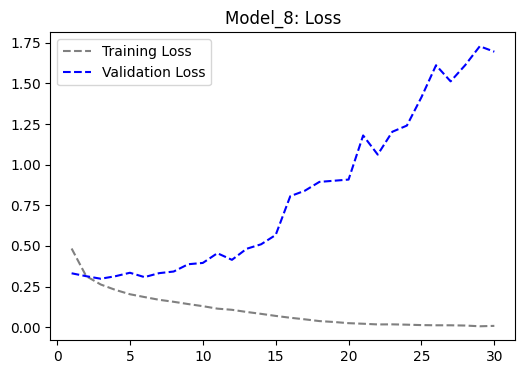

In [216]:
accuracy = Model_8.history['accuracy']
val_accuracy = Model_8.history['val_accuracy']

loss = Model_8.history["loss"]
val_loss = Model_8.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, accuracy, color="grey", linestyle="dashed", label="Training Accuracy")
plt.plot(epochs, val_accuracy, color="blue",linestyle="dashed", label="Validation Accuracy")
plt.title("Model_8:Accuracy")
plt.legend()
plt.figure()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, color="grey", linestyle="dashed", label="Training Loss")
plt.plot(epochs, val_loss, color="blue", linestyle="dashed", label="Validation Loss")
plt.title("Model_8: Loss")
plt.legend()
plt.show()

In [219]:
test_model = load_model('model8.h5', custom_objects={'TransformerEncoder': TransformerEncoder})

# Evaluate the model
Model8_Results = test_model.evaluate(test_texts, test_labels)
print(f'Loss: {Model8_Results[0]:.3f}')
print(f'Accuracy: {Model8_Results[1]:.3f}')

157/157 [==============================] - 1s 5ms/step - loss: 0.2639 - accuracy: 0.8926
Loss: 0.264
Accuracy: 0.893


Model 9:Pretrained

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-11-27 01:32:56--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-11-27 01:32:56--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-11-27 01:32:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

NameError: ignored

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

NameError: ignored

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

NameError: ignored

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")